In [111]:
import pandas as pd
import scanpy as sc
import glob
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt
import scipy as sp

In [112]:
from pathlib import Path
result_dir = '../figures/DAE_paper/'
sc._settings.ScanpyConfig.figdir = Path(result_dir)

<div class="alert alert-info">

**Note**
    
This notebook provides analysis on the critical gene analysis. 
    
</div>  

# Define parameters

In [113]:
# Different dataset have diffrerent column name to store the celltype
def get_ct(data): 
    if(data=="GSE110894"):
        return("Sample name")
    elif(data=="GSE117872_HN120"):
        return("cell_color")
    elif(data=="GSE117872_HN137"):
        return("cell_color")
    else:
        return("cell_color")

In [114]:
# Select DATA case as GSE117872
# The critical gene will be orderd by log fold change
DATA = "GSE117872"
PCT_EXP = 25
ORDER = 'log_fc'
sc.settings.set_figure_params(dpi=100, facecolor='white')

# Read critical gene names

The input of this step is a txt matrix file of the Captum calculated integrated gradients. Will be generated if we applied --printgene 'T' in the scmodel.py script. "sc_gradient.txt"

In [115]:
# Change it to your path that save h5ad for HN120 critical gene gradient
f_cg = glob.glob("../save/*"+DATA+"sc_gradient.txt")
df_cg = pd.read_csv(f_cg[0],sep=" ",header=None)

In [116]:
df_cg = pd.read_csv(f_cg[0],sep=" ",header=None)

In [117]:
# Change it to your path that save h5ad for HN120 critical gene name
f_gn = glob.glob("../save/*"+DATA+"sc_gene.csv")
df_gene = pd.read_csv(f_gn[0],index_col=0)

In [118]:
df_cg.columns = df_gene.iloc[:,0].values

# Read result h5ad files

In [119]:
# Change it to your path that saved h5ad for the case study
adata_fname = glob.glob("../save/adata/*"+DATA+"*h5ad")

In [120]:
adata_fname

['../save/adata/GSE117872integrate_data_GSE117872_drug_CISPLATIN_bottle_512_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.01_mod_new_sam_SMOTE.h5ad']

In [121]:
adata = sc.read_h5ad(adata_fname[0])

The metadata feil is shown as follows

In [122]:
adata.obs.head()

,cell_color,patient_id,origin,drug_status,cluster,pca_clusters,pagoda_clusters,Unnamed: 8,sensitive,sensitivity,...,pct_counts_rps,total_counts_rpl,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds
RHH2177,HN120P,cyan,HN120,Primary,Sensitive,4,2,3,1,Sensitive,...,5.728729,89409.552862,8.941138,3,3,0.906468,1,1.000000,1,4.218126e-07
RHH2178,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,6.369885,93044.306198,9.304439,3,3,0.016339,0,1.000000,1,3.973061e-09
RHH2179,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.890006,94809.311475,9.481582,3,3,0.665238,1,1.000000,1,8.599832e-08
RHH2180,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.437080,85402.506773,8.540501,3,3,0.998620,1,0.999999,1,7.663281e-07
RHH2181,HN120P,cyan,HN120,Primary,Sensitive,2,2,3,1,Sensitive,...,5.040665,82698.761218,8.269889,3,3,0.926435,1,0.999999,1,2.523028e-07


# Read result h5ad files

We organize different comparison groups stored in a map. Each group are selected subsets of the dataset. We will compare one versus rest comparisons with each other

In [123]:
map_ref_group = {
    1: ["HN120P",'HN120PCR'],
    2: ['HN120P',"HN120M"],
    3: ['HN120PCR','HN120MCR'],
    4: ['HN120P','HN120PCRDH','HN120PCR'],
    5: ['HN120M','HN120MCRDH','HN120MCR'],
}

In [124]:
df_cg.index = adata.obs.index

Propsessing the critical gene matrix

In [125]:
df_cg = abs(df_cg)
igadata= sc.AnnData(df_cg)
igadata.var.index = adata.var.index
igadata.obs.index = adata.obs.index
igadata.obs=adata.obs
igadata.obs['sens_label'] = adata.obs['sens_label'].astype('category')

In [126]:
sc.pp.filter_cells(igadata, min_genes=200)
sc.pp.filter_genes(igadata, min_cells=3)
#sc.pl.highest_expr_genes(igadata, n_top=20, )
sc.pp.normalize_total(igadata)
sc.pp.log1p(igadata)
sc.pp.highly_variable_genes(igadata, min_mean=0.0125, max_mean=3, min_disp=0.5)
igadata.obs['sens_label'] = adata.obs['sens_label'].astype('category')
rg_result = sc.tl.rank_genes_groups(igadata, 'sens_label',method='wilcoxon',pts=True)

Preview meta of the integrated gradient matrix

# Perform wilcoxon tests on integrated gradient values among clusters

View of AnnData object with n_obs × n_vars = 185 × 7158
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'rank_genes_groups'


/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarni

/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_

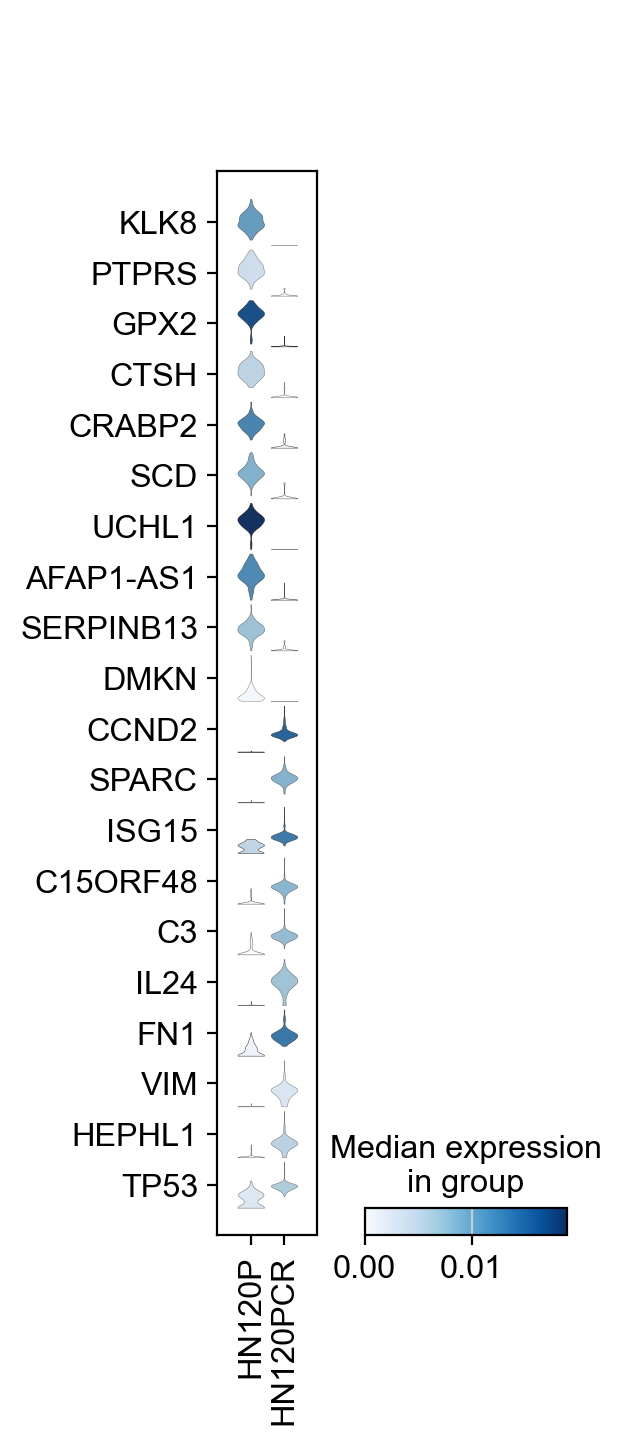

View of AnnData object with n_obs × n_vars = 181 × 7158
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'rank_genes_groups'


/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarni

/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_

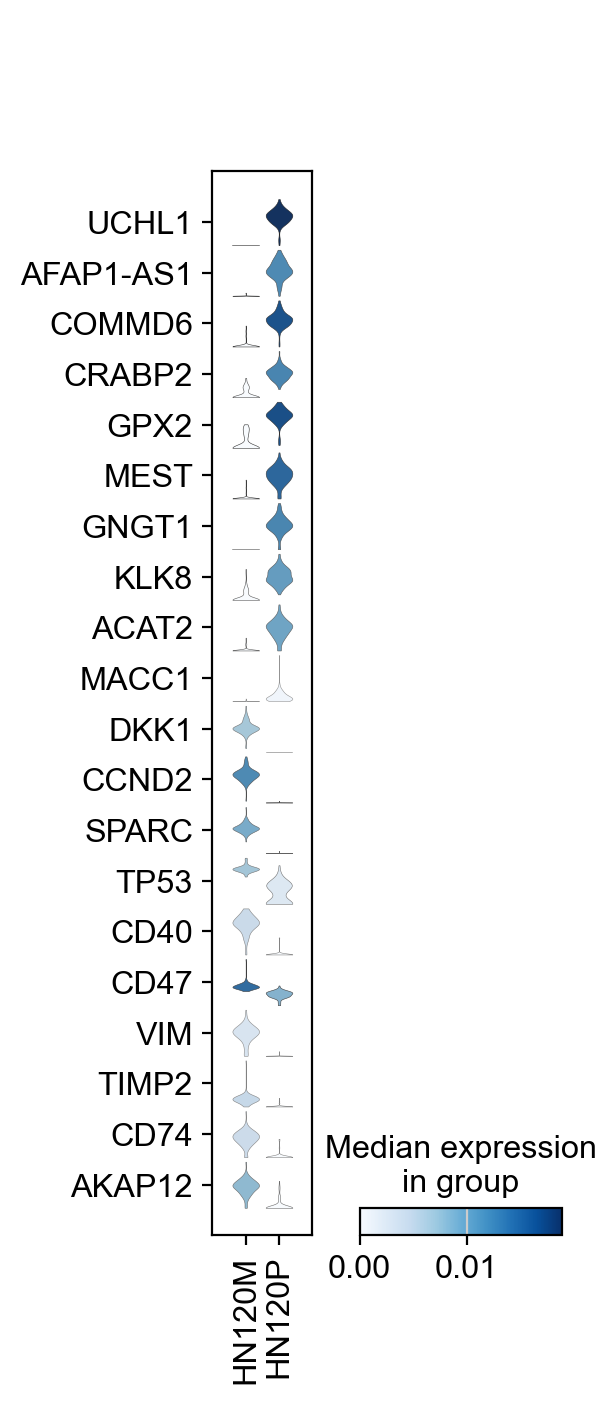

View of AnnData object with n_obs × n_vars = 187 × 7158
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'rank_genes_groups'


/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarni

/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_

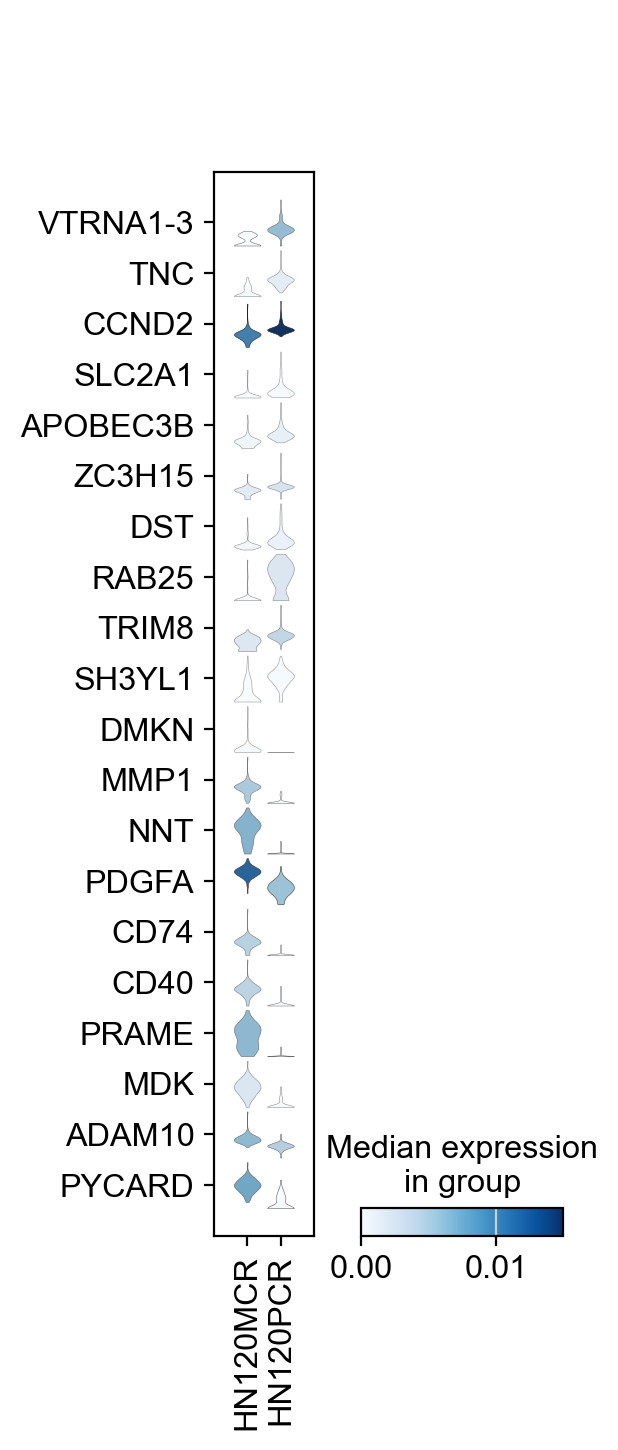

View of AnnData object with n_obs × n_vars = 278 × 7158
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'rank_genes_groups'


/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarni

/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_

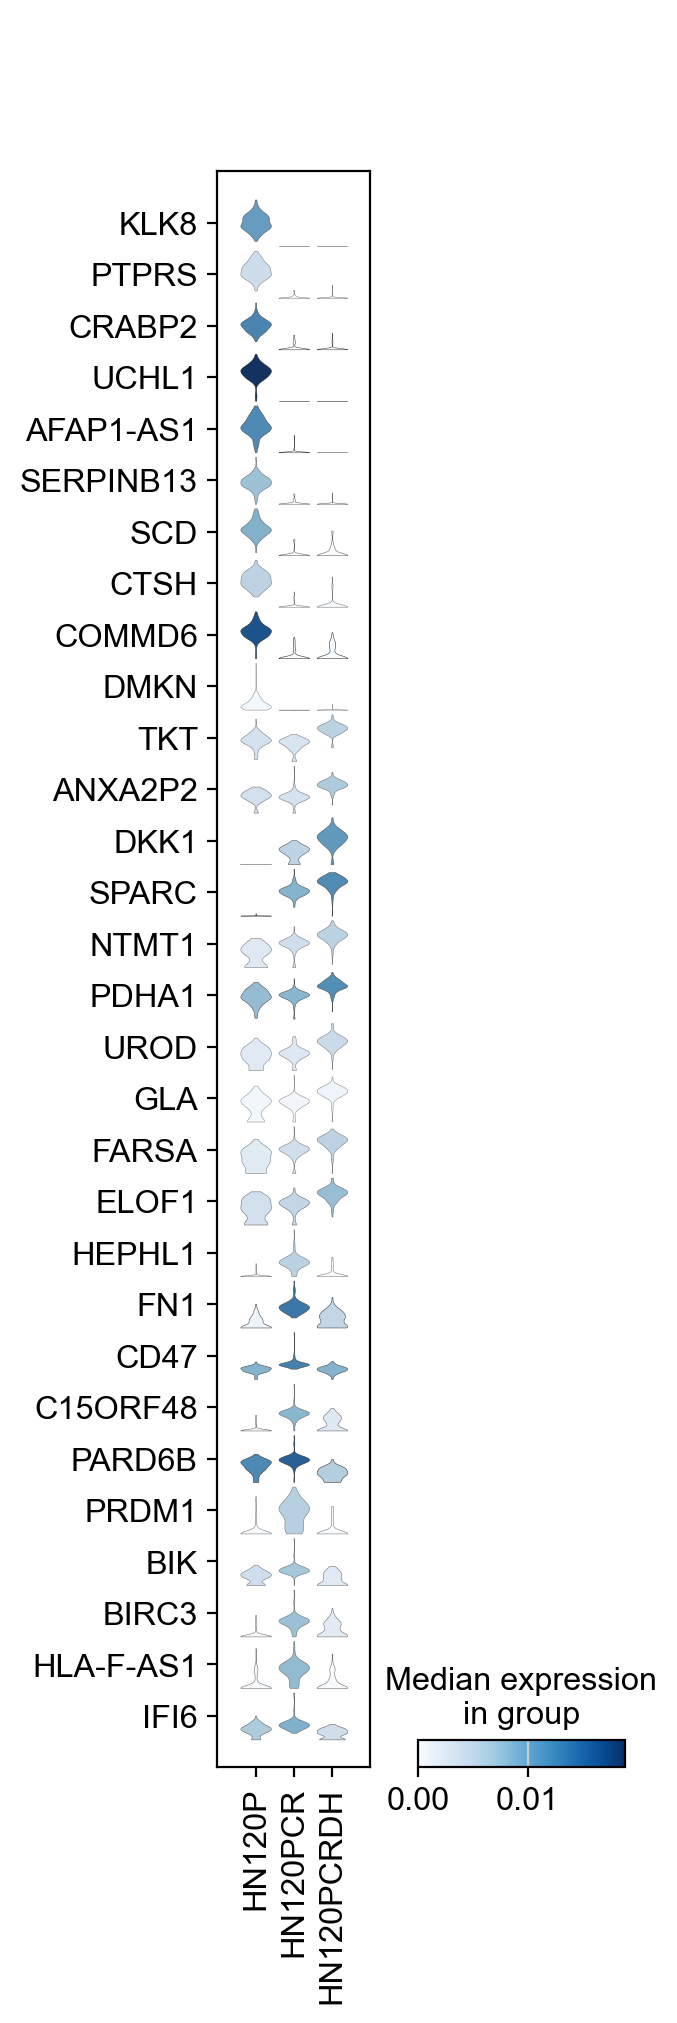

View of AnnData object with n_obs × n_vars = 270 × 7158
    obs: 'cell_color', 'patient_id', 'origin', 'drug_status', 'cluster', 'pca_clusters', 'pagoda_clusters', 'Unnamed: 8', 'sensitive', 'sensitivity', 'Resistant_score', 'Sensitive_score', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps', 'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden', 'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds', 'sens_label', 'rest_preds'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'rank_genes_groups'


/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/tools/_rank_genes_groups.py:582: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarni

/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_stacked_violin.py:461: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  row_ax = sns.violinplot(
/Users/azizilab/Applications/anaconda3/envs/kangroo/lib/python3.10/site-packages/scanpy/plotting/_

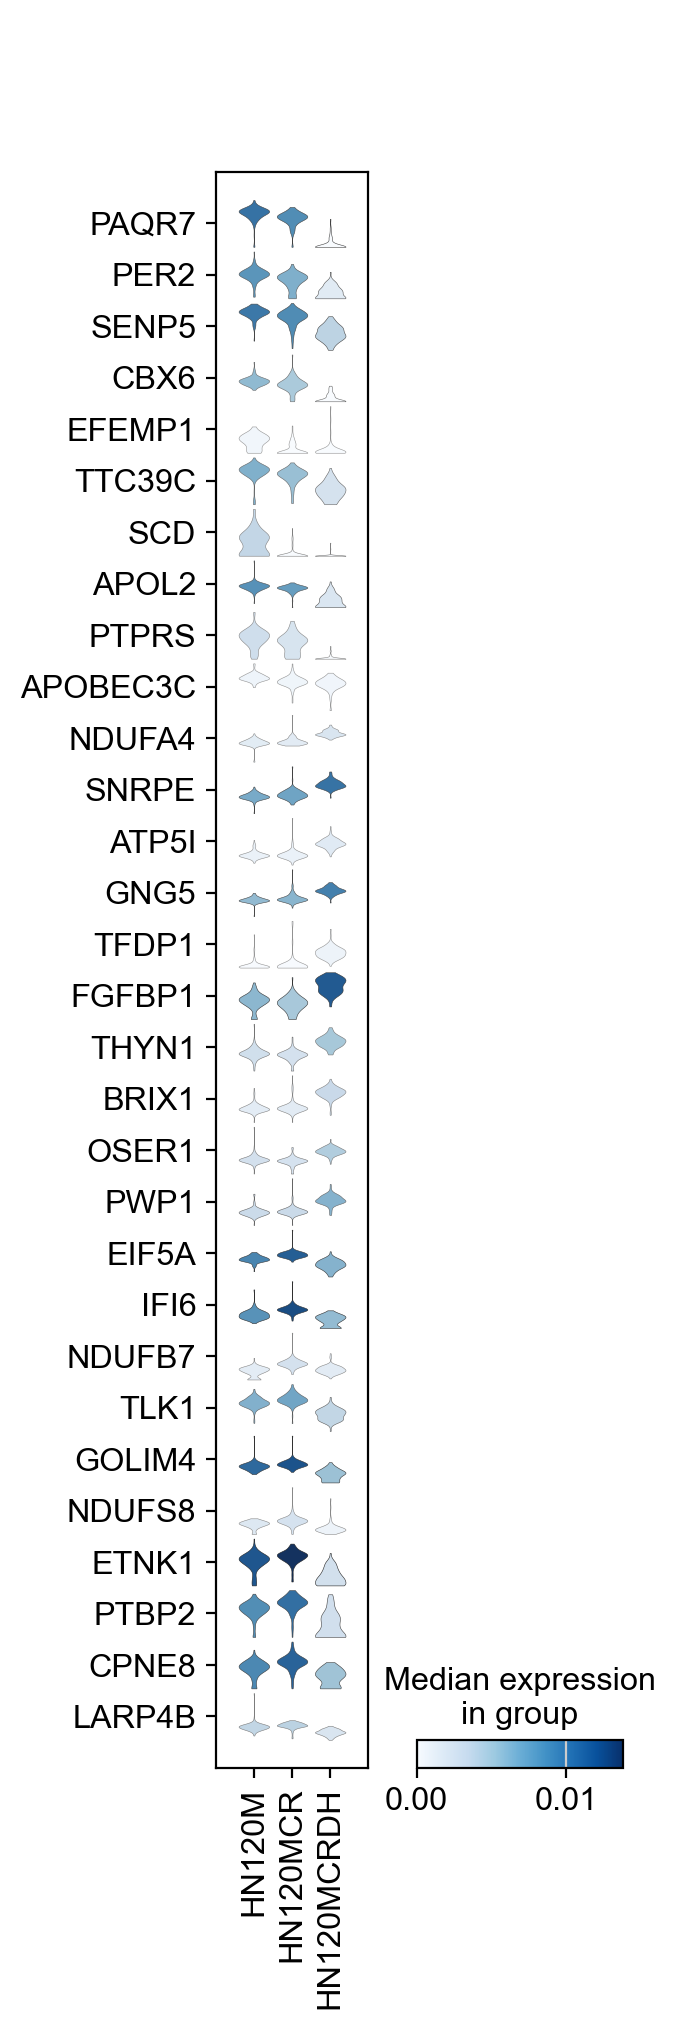

In [127]:
# Save the gene tables into csv files
for i in range(1,6):
    subset_igdata = igadata[igadata.obs['cell_color'].isin(map_ref_group[i])]
    print(subset_igdata)
    rg_result = sc.tl.rank_genes_groups(subset_igdata, 'cell_color', groups=map_ref_group[i], reference='rest', method='wilcoxon',pts =True)
    #sc.pl.rank_genes_groups(subset_igdata, groups=map_ref_group[i], n_genes=20,save="critical_genes_rank_"+str(clip)+str(i)+".svg")
    df_name = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['names'])#.to_csv("critical_genes_experiment_"+str(i)+".csv")
    df_lgfc = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['logfoldchanges'])#.to_csv("critical_logfc_experiment_"+str(i)+".csv")
    df_pval = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['pvals_adj'])#.to_csv("critical_genes_experiment_"+str(i)+".csv")
    df_pts = pd.DataFrame(subset_igdata.uns['rank_genes_groups']['pts'])#.to_csv("critical_logfc_experiment_"+str(i)+".csv")

    for c in df_name.columns:
        tmp_df = pd.DataFrame({"gene_name":df_name[c],"log_fc":df_lgfc[c],'pvals_adj':df_pval[c],'pts':df_pts.loc[df_name[c].values,c].values})
        tmp_df.to_csv(result_dir+"critical_genes_experiment_"+str(i)+"_type_"+str(c)+"_vs_others.csv")

    sc.pl.stacked_violin(subset_igdata, pd.DataFrame(subset_igdata.uns['rank_genes_groups']['names']).head(10).T.values.ravel(), groupby='cell_color',\
                        swap_axes=True,save="critical_genes_violint_"+str(i)+".svg"
                        );

# Filter critical gens by logfc val and percentages

In [128]:
gene = pd.read_csv("critical_genes_experiment_1_type_HN120P_vs_others.csv")
gene = gene[gene['log_fc'].abs()>0.1]
gene = gene[gene['pvals_adj']<=0.05]
gene = gene[gene['pts']>0.2]
gene=gene.sort_values("log_fc",ascending=True)
res = list(gene[gene['log_fc']<0]['gene_name'])
gene=gene.sort_values("log_fc",ascending=False)
sen=list(gene[gene['log_fc']>0]['gene_name'])

Print head sensitive critical genes and resistant genes

In [129]:
print(res[:10])

['FANK1', 'GABPB1-AS1', 'ZNF141', 'MIR4426', 'LRRC42', 'ATF6B', 'CREBRF', 'ECH1', 'CBWD3', 'APOBEC3C']


In [130]:
print(sen[:10])

['UCHL1', 'GNGT1', 'KLK8', 'EDIL3', 'SLC7A8', 'C3ORF14', 'ACKR3', 'SESN3', 'PRSS3', 'NEFL']
